In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
%matplotlib inline

In [2]:
22%15

7

In [88]:
L = 100 # Длина основания
H = 150 # Высота всей детали
R = 15  # Радиусы малых окружностей
RR = 70 # Радиус большой окружности
W = 15  # Толщина стенки

In [89]:
def split_border(nodes, n, closed_contour=False):
    result = np.array([])
    
    ln = nodes.shape[0]-1
    
    for i in range(nodes.shape[0]-1):
        res_xs = np.linspace(nodes[i,0], nodes[i+1,0], n)[:-1]
        res_ys = np.linspace(nodes[i,1], nodes[i+1,1], n)[:-1]
        result = np.append(result, np.hstack((np.array(res_xs).reshape(-1,1), np.array(res_ys).reshape(-1,1))))

    if not closed_contour and n:
        result = np.append(result, np.hstack((np.array(nodes[:,0][-1]).reshape(-1,1), np.array(nodes[:,1][-1]).reshape(-1,1))))
        
    return result.reshape(-1, 2)

In [90]:
def gen_arc(center, R, alpha1, alpha2, n):
    alpha1 = np.radians(np.linspace(alpha1, alpha2, n))

    x1 = R * np.cos(alpha1) + center[0]
    y1 = R * np.sin(alpha1) + center[1]
    
    return np.hstack((x1.reshape(-1, 1), y1.reshape(-1, 1)))

In [91]:
def len_poly(poly):
    return np.sum(np.linalg.norm(poly[:-1]-poly[1:], axis=1))

In [92]:
def calculate_upper_smaller_circle_y_and_touch_point(R, W, RR):
    """ VERY IMPORTANT FUNCTION. Calculations form Mathematica 11 :)"""
    RR_outer = RR + W # Outer big circle radius

    touch_point_x = ((2.*R + W)*RR_outer)/(2.* (R + RR_outer))
    touch_point_y = (300.* R**2 + 600.* R *RR_outer + 300.* RR_outer**2 - np.sqrt(RR_outer**2 *(R + RR_outer)**2 *(-W + 2.*RR_outer) *(4.* R + W + 2.* RR_outer)))/(2.* (R + RR_outer)**2)
    small_circle_center_y = (300.* R*RR_outer + 300.* RR_outer**2 - np.sqrt(RR_outer**2* (R + RR_outer)**2* (-W + 2.* RR_outer)* (4.* R + W + 2.* RR_outer)))/(2.* RR_outer* (R + RR_outer))
    
    return (touch_point_x, touch_point_y, small_circle_center_y)

In [93]:
touch_point_x, touch_point_y, small_circle_center_y = calculate_upper_smaller_circle_y_and_touch_point(R, W, RR)

In [94]:
circ_big = np.array([0., 150])          # Inner and outer big circles
circle_lr = np.array([W/2. + R, W + R]) # Low right circle center
circle_ur = np.array([R + W/2., small_circle_center_y]) # Upper right circle center
circle_ul = np.array([-1.*(R + W/2.), small_circle_center_y]) # Upper left circle center
circle_ll = np.array([-1*(W/2. + R), W+R]) # Lower left circle center

In [95]:
NUMSPLITS = 20
CM_PER_SPLIT = 2
SPLITS_COEFF = 1./CM_PER_SPLIT

In [96]:
# Введем также константы для длин окружностей
theta = np.rad2deg(np.arcsin(touch_point_x/(RR+W)))
theta1 = np.rad2deg(np.arcsin((circle_ur[0]-touch_point_x)/R))
upper_circle_len = (2.*np.pi*RR)/2.
small_circles_len = (np.pi * R * (90. - theta))/180.
lower_circles_len = (np.pi * (RR+W) * (90. - theta))/180.

In [97]:
border_part1 = np.array([
    [-50, 0],
    [50, 0],
    [50, W],
    [W/2.+R, W]
], dtype=float)
circ1 = gen_arc(circle_lr, R, 270, 180, int(small_circles_len*SPLITS_COEFF))[1:-1] # Except first and last point
                                                            # because we have border points there
border_part2 = np.array([
    [W/2., W+R],
    [W/2, circle_ur[1]]
], dtype=float)
circ2 = gen_arc(circle_ur, R, 180, 90+theta1, int(small_circles_len*SPLITS_COEFF))[1:-1] # Except first and last point
                                                           # because we have border and other arc points there
circ3_alpha1 = theta
circ3 = gen_arc(circ_big, RR+W, 270+circ3_alpha1, 360., int(lower_circles_len*SPLITS_COEFF))[:-1] # Except only last point because
                                                                        # we threw away last point of the previous arc

border_part3 = np.array([
    [RR+W, H],
    [RR, H]
])

circ4 = gen_arc(circ_big, RR, 360, 180, int(upper_circle_len*SPLITS_COEFF))[1:-1]

border_part4 = np.array([
    [-1.*RR, H],
    [-1*RR-W, H]
])

circ5 = gen_arc(circ_big, RR+W, 180, 270-circ3_alpha1, int(lower_circles_len*SPLITS_COEFF))[1:-1]

circ6 = gen_arc(circle_ul, R, 90-theta1, 0, int(small_circles_len*SPLITS_COEFF))[:-1]

border_part5 = np.array([
    [-1*W/2., circle_ul[1]],
    [-1*W/2., W+R]
])

circ7 = gen_arc(circle_ll, R, 360, 270, int(small_circles_len*SPLITS_COEFF))[1:-1]

border_part6 = np.array([
    [-1*(W/2.+R), W],
    [-50, W],
    [-50, 0.]
])

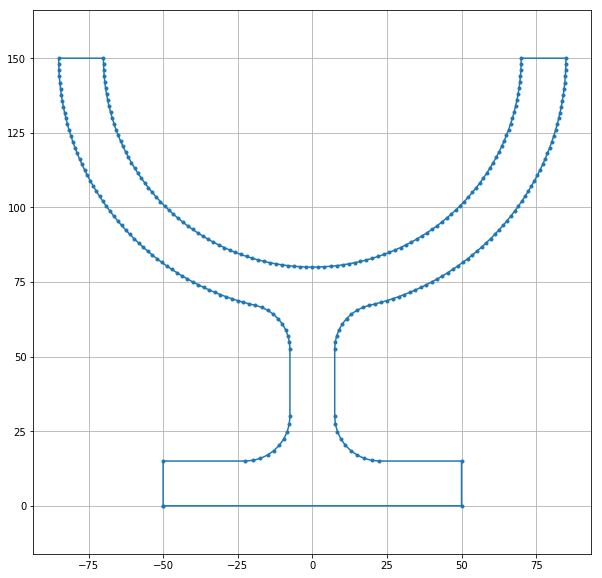

In [98]:
plt.figure(figsize=(10, 10))
rr = np.vstack([border_part1, circ1, border_part2, circ2, circ3, border_part3, circ4, border_part4,
                circ5, circ6, border_part5, circ7, border_part6])
plt.plot(rr[:,0], rr[:,1], '.-')
plt.axis('equal')
plt.grid(True)

In [99]:
# For border part1
border_part1_sp_1 = split_border(border_part1[:2], int(L*SPLITS_COEFF))
border_part1_sp_2 = split_border(border_part1[1:3], int(W*SPLITS_COEFF))
border_part1_sp_3 = split_border(border_part1[2:], int((L/2. - R)*SPLITS_COEFF))
border_part1_sp = np.vstack([border_part1_sp_1, border_part1_sp_2, border_part1_sp_3])

border_part2_sp = split_border(border_part2, int(len_poly(border_part2)*SPLITS_COEFF))
border_part3_sp = split_border(border_part3, int(W*SPLITS_COEFF))
border_part4_sp = split_border(border_part4, int(W*SPLITS_COEFF))
border_part5_sp = split_border(border_part5, int(len_poly(border_part5)*SPLITS_COEFF))

# For border part6
border_part6_sp_1 = split_border(border_part6[:2], int((L/2. - R)*SPLITS_COEFF))
border_part6_sp_2 = split_border(border_part6[1:], int(W*SPLITS_COEFF))[:-1]
border_part6_sp = np.vstack([border_part6_sp_1, border_part6_sp_2])

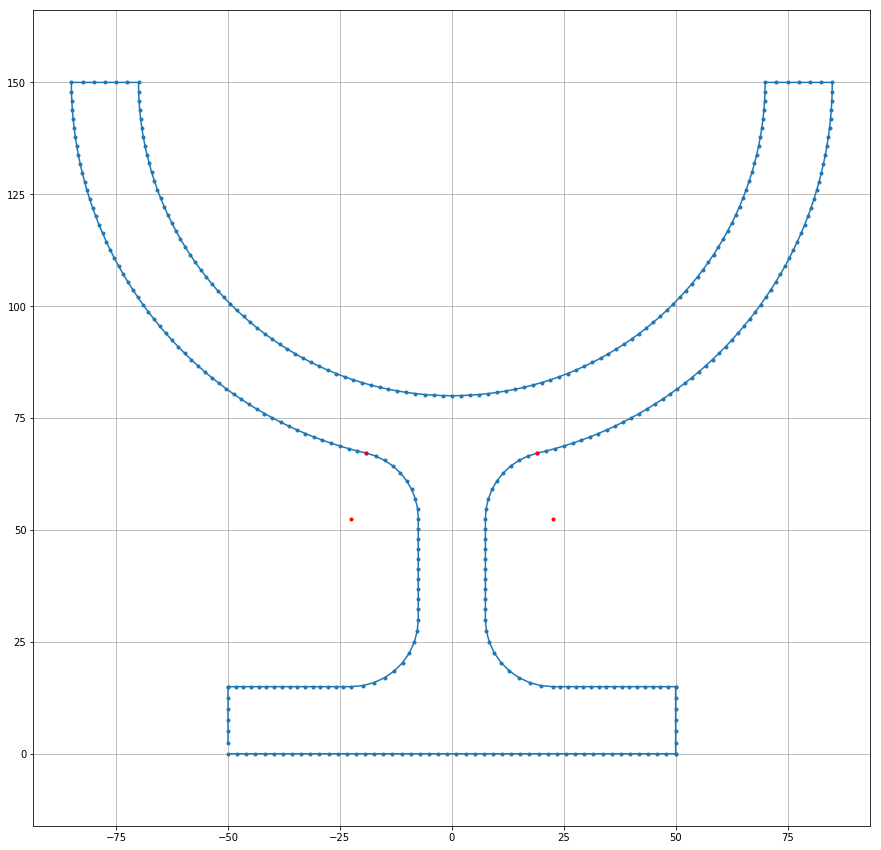

In [100]:
border = np.vstack([border_part1_sp, circ1, border_part2_sp, circ2, circ3, border_part3_sp, circ4, border_part4_sp,
                circ5, circ6, border_part5_sp, circ7, border_part6_sp])
plt.figure(figsize=(15, 15))
plt.plot(border[:,0], border[:,1], '.-')
plt.plot([touch_point_x], [touch_point_y], 'r.')
plt.plot([W/2+R], [small_circle_center_y], 'r.')

plt.plot([-1*touch_point_x], [touch_point_y], 'r.')
plt.plot([-1*(W/2 + R)], [small_circle_center_y], 'r.')

plt.axis('equal')
plt.grid(True)

In [101]:
circ6[1:-1]

array([[-16.98832888,  66.51480397],
       [-14.9743155 ,  65.53964186],
       [-13.12778007,  64.27572019],
       [-11.48981573,  62.75116652],
       [-10.09687405,  60.99990853],
       [ -8.97995379,  59.06091905],
       [ -8.16391111,  56.9773487 ]])

In [102]:
circ2[1:-1]

array([[ 8.16391111, 56.9773487 ],
       [ 8.97995379, 59.06091905],
       [10.09687405, 60.99990853],
       [11.48981573, 62.75116652],
       [13.12778007, 64.27572019],
       [14.9743155 , 65.53964186]])

(-93.5, 93.5, -7.5, 157.5)

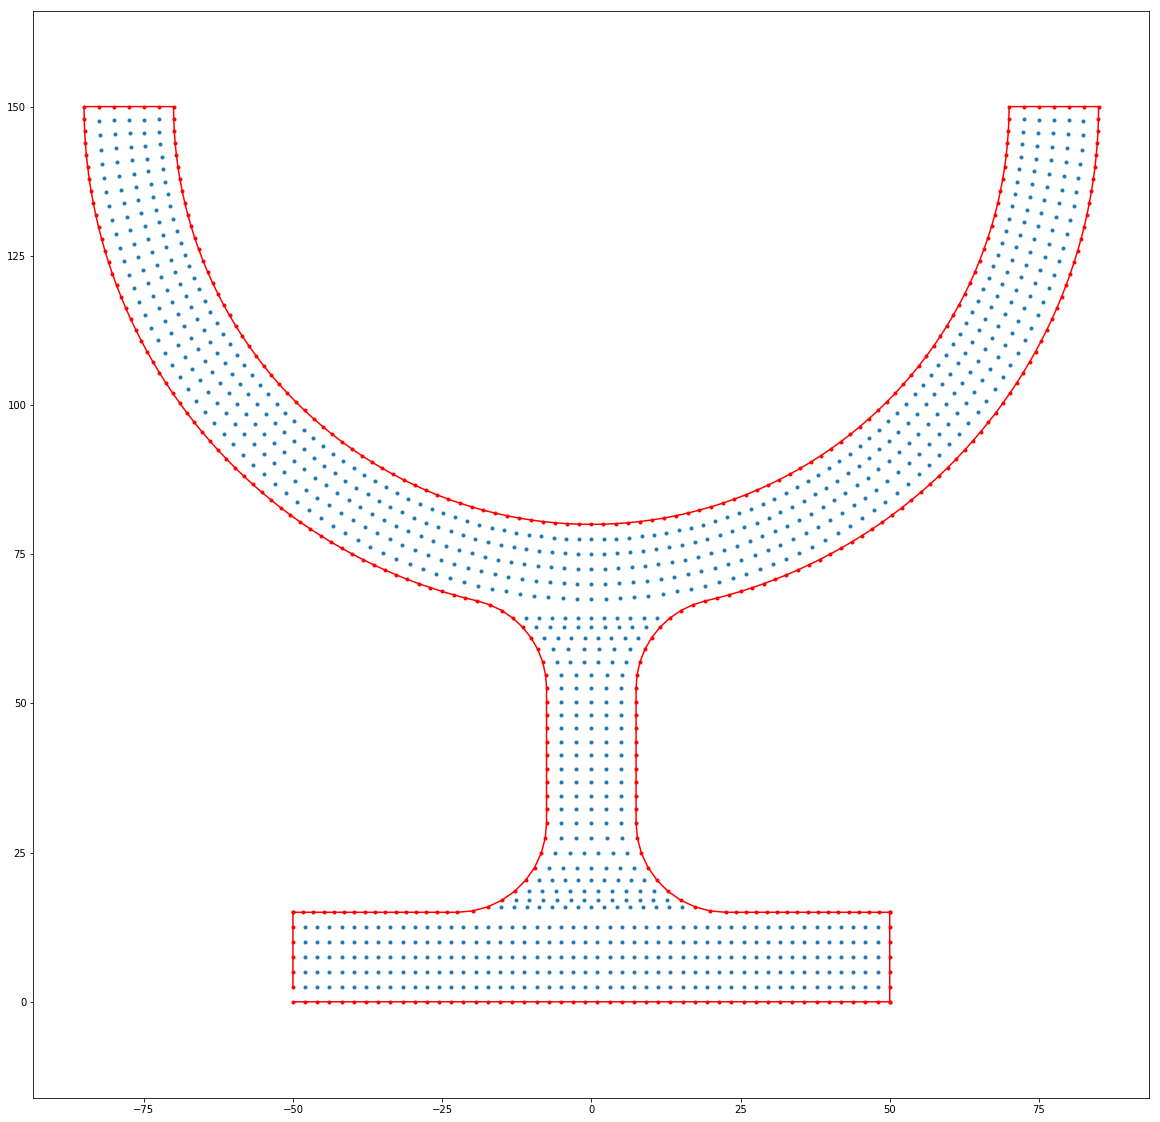

In [138]:
delta_x=0.5
delta_y=2

# Mesh for upper part
mesh_upper = []
for i in np.linspace(0, W, int(W*SPLITS_COEFF)):
    arc = gen_arc(circ_big, RR+i, 360, 180, int(upper_circle_len*SPLITS_COEFF))[1:-1]
    mesh_upper.append(arc)

#arc_middle_fix = gen_arc(circ_big, RR+i, 270.+(theta-theta/3.), 270.-(theta-theta/3.), int((np.pi*(RR+W)*(2.*(theta-theta/3.)))/180.*SPLITS_COEFF))
mesh_upper = mesh_upper[1:-1] # Throw away first and last arcs
#mesh_upper.append(arc_middle_fix)
mesh_upper = np.vstack(mesh_upper)

# Mesh for lower part
#mesh_lower = []
#border_to_copy = border_part1[:2].copy()
#for i in np.linspace(0., circle_ur[1], int(circle_ur[1]*SPLITS_COEFF)):
#    mesh_lower.append(split_border(border_to_copy+np.array([[0.,i],[0.,i]]), int(L*SPLITS_COEFF))[1:-1])
#mesh_lower = mesh_lower[1:]
#mesh_lower = np.vstack(mesh_lower)

# Mesh inbetween
mesh_inbetween = []
for pt_circ_left, pt_circ_right in zip(circ6[::-1], circ2):
    start_stop = np.array([pt_circ_left, pt_circ_right])
    start_stop_sp = split_border(start_stop, int(len_poly(start_stop)*SPLITS_COEFF))[1:-1]
    if np.any(start_stop_sp[:,1] > H-RR-W):
        break
    mesh_inbetween.append(start_stop_sp)
mesh_inbetween = np.vstack(mesh_inbetween)

# Mesh for rectangular part between base and top
mesh_inbetween1 = []
for pt_bord_left, pt_bord_right in zip(border_part2_sp[::-1], border_part5_sp):
    start_stop = np.array([pt_bord_left, pt_bord_right])
    start_stop_sp = split_border(start_stop, int(W*SPLITS_COEFF))[1:-1]
    mesh_inbetween1.append(start_stop_sp)
mesh_inbetween1 = np.vstack(mesh_inbetween1)

# Mesh for lower transition area
mesh_inbetween2 = []
for pt_circ_left, pt_circ_right in zip(circ1[::-1][:-1], circ7[:-1]):
    start_stop = np.array([pt_circ_left, pt_circ_right])
    start_stop_sp = split_border(start_stop, int(len_poly(start_stop)*SPLITS_COEFF))[1:-1]
    mesh_inbetween2.append(start_stop_sp)
mesh_inbetween2 = np.vstack(mesh_inbetween2)

# Mesh for lower rectangle
mesh_lower = []
border_to_copy = border_part1[:2].copy()
for i in np.linspace(0., W, int(W*SPLITS_COEFF)):
    mesh_lower.append(split_border(border_to_copy+np.array([[0.,i],[0.,i]]), int(L*SPLITS_COEFF))[1:-1])
mesh_lower = mesh_lower[1:-1]
mesh_lower = np.vstack(mesh_lower)

inner = np.vstack([mesh_upper, mesh_inbetween, mesh_inbetween1, mesh_inbetween2, mesh_lower])
plt.figure(figsize=(20, 20))
plt.plot(inner[:,0], inner[:,1], '.')
plt.plot(border[:,0], border[:,1], 'r.-')
plt.axis('equal')

In [132]:
inner

array([[ 72.46932888, 147.89135789],
       [ 72.37734147, 145.7844999 ],
       [ 72.22411561, 143.68120865],
       ...,
       [ 43.87755102,  12.5       ],
       [ 45.91836735,  12.5       ],
       [ 47.95918367,  12.5       ]])

In [134]:
def circular_mask(inner, circ_center, radius, delta=0):
    """True for points outside the circle"""
    mask = np.sum(np.power(inner - circ_center, 2), axis=1) > np.power(radius+delta, 2)
    return mask

In [135]:
def rectangular_mask(inner, lower_end_pt, h, w, delta=0):
    """True for points outside the rectangle"""
    mask = (inner[:,0] >= lower_end_pt[0]+delta) & (inner[:,0] <= lower_end_pt[0]+w-delta) &\
           (inner[:,1] >= lower_end_pt[1]+delta) & (inner[:,1] <= lower_end_pt[1]+h-delta)
    return np.logical_not(mask)

In [136]:
def transition_mask_upper(inner, big_radius, big_circle_center, small_radius, 
                    small_circle_center_left, small_circle_center_right, lower_plane_y, width, delta=0):
    
    mask1 = circular_mask(inner, big_circle_center, big_radius+width, delta)
    mask2 = circular_mask(inner, small_circle_center_left, small_radius, delta)
    mask3 = circular_mask(inner, small_circle_center_right, small_radius, delta)
    mask4 = (inner[:,0] > small_circle_center_left[0]) & (inner[:,0] < small_circle_center_right[0])
    mask5 = inner[:,1] > lower_plane_y
    
    return mask1 & mask2 & mask3 & mask4 & mask5

def transition_mask_lower(inner, small_circle_radius, small_circle_center_left, 
                          small_circle_center_right, lower_plane_y, upper_plane_y, delta=0):
    mask1 = circular_mask(inner, small_circle_center_left, small_circle_radius, delta)
    mask2 = circular_mask(inner, small_circle_center_right, small_circle_radius, delta)
    mask3 = (inner[:,0] > small_circle_center_left[0]) & (inner[:,0] < small_circle_center_right[0])
    mask4 = (inner[:,1] > lower_plane_y) & (inner[:,1] < upper_plane_y)
    
    return mask1 & mask2 & mask3 & mask4

(-93.5, 93.5, -7.5, 157.5)

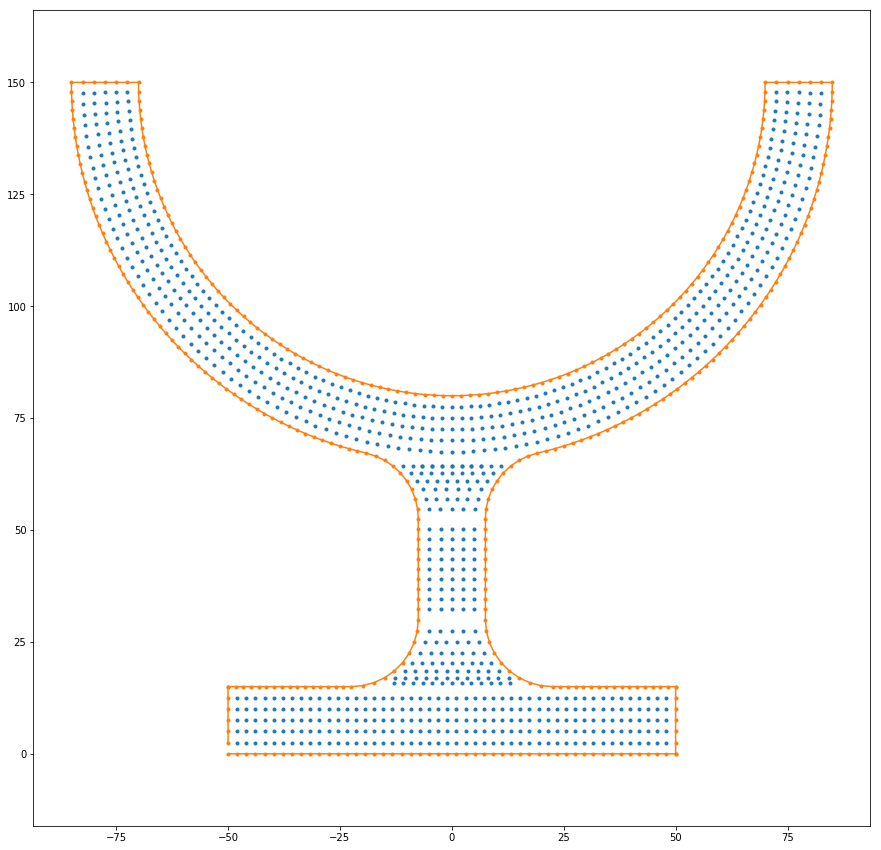

In [137]:
mask_delta = 1

# For inner points inside big and bigger upper circles
mask_big_circle = circular_mask(inner, circ_big, RR, delta=1)
mask_bigger_circle = circular_mask(inner, circ_big, RR+W, delta=1)

# For points inside transition areas and rectangle inbetween
transition1 = transition_mask_upper(inner, RR, circ_big, R, circle_ul, circle_ur, circle_ur[1], W, delta=0)
transition2 = transition_mask_lower(inner, R, circle_ll, circle_lr, W, W+R, delta=1)
retangle_inbetween = rectangular_mask(inner, border_part5[-1], np.linalg.norm(border_part5[0] - border_part5[1]), W, 0.5)

# For points inside rectangular base
rectangle_base = rectangular_mask(inner, [-1*L/2., 0.], W, L, 0.5)

# Construct resulting points
inner_upper = inner[mask_big_circle & np.logical_not(mask_bigger_circle)]
inner_lower = inner[transition1 | transition2 | np.logical_not(retangle_inbetween) | np.logical_not(rectangle_base)]
inner_masked = np.vstack([inner_upper, inner_lower])

plt.figure(figsize=(15, 15))
plt.plot(inner_masked[:,0], inner_masked[:,1], '.')
plt.plot(border[:,0], border[:,1], '.-')
plt.axis('equal')

In [143]:
inner_masked = inner

In [144]:
Nodes = np.vstack((border, inner_masked))

In [145]:
trng = scipy.spatial.Delaunay(Nodes)

In [146]:
trng_vertices = Nodes[trng.simplices.copy()]
trng_x_vertices = trng_vertices[:, :, 0]
trng_y_vertices = trng_vertices[:, :, 1]

trng_x_mean = np.mean(trng_x_vertices, axis=1)
trng_y_mean = np.mean(trng_y_vertices, axis=1)

trng_centers = np.hstack((trng_x_mean.reshape(-1, 1), trng_y_mean.reshape(-1, 1)))

simplices = trng.simplices.copy()

# For inner points inside big and bigger upper circles
mask_big_circle = circular_mask(trng_centers, circ_big, RR)
mask_bigger_circle = circular_mask(trng_centers, circ_big, RR+W)

# For points inside transition areas and rectangle inbetween
transition1 = transition_mask_upper(trng_centers, RR, circ_big, R, circle_ul, circle_ur, circle_ur[1], W)
transition2 = transition_mask_lower(trng_centers, R, circle_ll, circle_lr, W, W+R)
retangle_inbetween = rectangular_mask(trng_centers, border_part5[-1], np.linalg.norm(border_part5[0] - border_part5[1]), W)

# For points inside rectangular base
rectangle_base = rectangular_mask(trng_centers, [-1*L/2., 0.], W, L, delta=-2)

simplices1 = simplices[mask_big_circle & np.logical_not(mask_bigger_circle)]
simplices2 = simplices[transition1 | transition2 | np.logical_not(retangle_inbetween) | np.logical_not(rectangle_base)]
simplices = np.vstack([simplices1, simplices2])

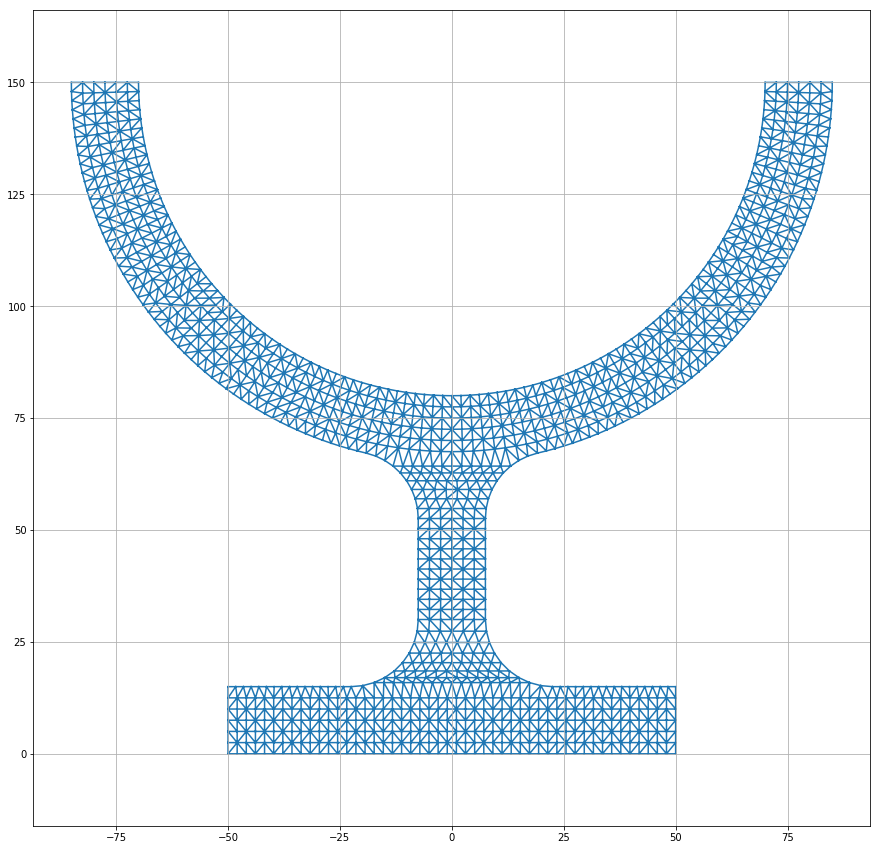

In [147]:
plt.figure(figsize=(15, 15))
plt.triplot(Nodes[:, 0], Nodes[:, 1], simplices)
plt.axis('equal')
##plt.xlim(-43, -20)
#plt.ylim(60, 80)
plt.grid(True)

In [155]:
W*SPLITS_COEFF

7.5

In [209]:
def construct_figure(W, R, cm_per_split=2):
    SPLITS_COEFF = 1./cm_per_split
    
    # ----> Constants
    L = 100 # Длина основания
    H = 150 # Высота всей детали
    RR = 70 # Радиус большой окружности
    
    touch_point_x, touch_point_y, small_circle_center_y = calculate_upper_smaller_circle_y_and_touch_point(R, W, RR)
    
    circ_big = np.array([0., 150])          # Inner and outer big circles
    circle_lr = np.array([W/2. + R, W + R]) # Low right circle center
    circle_ur = np.array([R + W/2., small_circle_center_y]) # Upper right circle center
    circle_ul = np.array([-1.*(R + W/2.), small_circle_center_y]) # Upper left circle center
    circle_ll = np.array([-1*(W/2. + R), W+R]) # Lower left circle center
    
    # Введем также константы для длин окружностей
    theta = np.rad2deg(np.arcsin(touch_point_x/(RR+W)))
    theta1 = np.rad2deg(np.arcsin((circle_ur[0]-touch_point_x)/R))
    upper_circle_len = (2.*np.pi*RR)/2.
    small_circles_len = (np.pi * R * (90. - theta))/180.
    lower_circles_len = (np.pi * (RR+W) * (90. - theta))/180.

    border_part1 = np.array([
        [-50, 0],
        [50, 0],
        [50, W],
        [W/2.+R, W]
    ], dtype=float)
    circ1 = gen_arc(circle_lr, R, 270, 180, int(small_circles_len*SPLITS_COEFF))[1:-1] # Except first and last point
                                                                # because we have border points there
    border_part2 = np.array([
        [W/2., W+R],
        [W/2, circle_ur[1]]
    ], dtype=float)
    circ2 = gen_arc(circle_ur, R, 180, 90+theta1, int(small_circles_len*SPLITS_COEFF))[1:-1] # Except first and last point
                                                               # because we have border and other arc points there
    circ3_alpha1 = theta
    circ3 = gen_arc(circ_big, RR+W, 270+circ3_alpha1, 360., int(lower_circles_len*SPLITS_COEFF))[:-1] # Except only last point because
                                                                            # we threw away last point of the previous arc

    border_part3 = np.array([
        [RR+W, H],
        [RR, H]
    ])

    circ4 = gen_arc(circ_big, RR, 360, 180, int(upper_circle_len*SPLITS_COEFF))[1:-1]

    border_part4 = np.array([
        [-1.*RR, H],
        [-1*RR-W, H]
    ])

    circ5 = gen_arc(circ_big, RR+W, 180, 270-circ3_alpha1, int(lower_circles_len*SPLITS_COEFF))[1:-1]

    circ6 = gen_arc(circle_ul, R, 90-theta1, 0, int(small_circles_len*SPLITS_COEFF))[:-1]

    border_part5 = np.array([
        [-1*W/2., circle_ul[1]],
        [-1*W/2., W+R]
    ])

    circ7 = gen_arc(circle_ll, R, 360, 270, int(small_circles_len*SPLITS_COEFF))[1:-1]

    border_part6 = np.array([
        [-1*(W/2.+R), W],
        [-50, W],
        [-50, 0.]
    ])
    
    # ----> Split border
    # For border part1
    border_part1_sp_1 = split_border(border_part1[:2], int(L*SPLITS_COEFF))
    border_part1_sp_2 = split_border(border_part1[1:3], int(W*SPLITS_COEFF))
    border_part1_sp_3 = split_border(border_part1[2:], int((L/2. - R)*SPLITS_COEFF))
    border_part1_sp = np.vstack([border_part1_sp_1, border_part1_sp_2, border_part1_sp_3])

    border_part2_sp = split_border(border_part2, int(len_poly(border_part2)*SPLITS_COEFF))
    border_part3_sp = split_border(border_part3, int(W*SPLITS_COEFF))
    border_part4_sp = split_border(border_part4, int(W*SPLITS_COEFF))
    border_part5_sp = split_border(border_part5, int(len_poly(border_part5)*SPLITS_COEFF))

    # For border part6
    border_part6_sp_1 = split_border(border_part6[:2], int((L/2. - R)*SPLITS_COEFF))
    border_part6_sp_2 = split_border(border_part6[1:], int(W*SPLITS_COEFF))[:-1]
    border_part6_sp = np.vstack([border_part6_sp_1, border_part6_sp_2])
    
    border = np.vstack([border_part1_sp, circ1, border_part2_sp, circ2, circ3, border_part3_sp, circ4, border_part4_sp,
                circ5, circ6, border_part5_sp, circ7, border_part6_sp])
    
    # ----> Construct meshes
    delta_x=0.5
    delta_y=2

    # Mesh for upper part
    mesh_upper = []
    for i in np.linspace(0, W, int(W*SPLITS_COEFF)):
        arc = gen_arc(circ_big, RR+i, 360, 180, int(upper_circle_len*SPLITS_COEFF))[1:-1]
        mesh_upper.append(arc)

    #arc_middle_fix = gen_arc(circ_big, RR+i, 270.+(theta-theta/3.), 270.-(theta-theta/3.), int((np.pi*(RR+W)*(2.*(theta-theta/3.)))/180.*SPLITS_COEFF))
    mesh_upper = mesh_upper[1:-1] # Throw away first and last arcs
    #mesh_upper.append(arc_middle_fix)
    mesh_upper = np.vstack(mesh_upper)

    # Mesh inbetween
    mesh_inbetween = []
    for pt_circ_left, pt_circ_right in zip(circ6[::-1], circ2):
        start_stop = np.array([pt_circ_left, pt_circ_right])
        start_stop_sp = split_border(start_stop, int(len_poly(start_stop)*SPLITS_COEFF))[1:-1]
        if np.any(start_stop_sp[:,1] > H-RR-W):
            break
        mesh_inbetween.append(start_stop_sp)
    mesh_inbetween = np.vstack(mesh_inbetween)

    # Mesh for rectangular part between base and top
    mesh_inbetween1 = []
    for pt_bord_left, pt_bord_right in zip(border_part2_sp[::-1], border_part5_sp):
        start_stop = np.array([pt_bord_left, pt_bord_right])
        start_stop_sp = split_border(start_stop, int(W*SPLITS_COEFF))[1:-1]
        mesh_inbetween1.append(start_stop_sp)
    mesh_inbetween1 = np.vstack(mesh_inbetween1)

    # Mesh for lower transition area
    mesh_inbetween2 = []
    for pt_circ_left, pt_circ_right in zip(circ1[::-1][:-1], circ7[:-1]):
        start_stop = np.array([pt_circ_left, pt_circ_right])
        start_stop_sp = split_border(start_stop, int(len_poly(start_stop)*SPLITS_COEFF))[1:-1]
        mesh_inbetween2.append(start_stop_sp)
    mesh_inbetween2[-1][:,1] -= SPLITS_COEFF
    mesh_inbetween2 = np.vstack(mesh_inbetween2)

    # Mesh for lower rectangle
    mesh_lower = []
    border_to_copy = border_part1[:2].copy()
    for i in np.linspace(0., W, int(W*SPLITS_COEFF)):
        mesh_lower.append(split_border(border_to_copy+np.array([[0.,i],[0.,i]]), int(L*SPLITS_COEFF))[1:-1])
    mesh_lower = mesh_lower[1:-1]
    mesh_lower = np.vstack(mesh_lower)

    inner = np.vstack([mesh_upper, mesh_inbetween, mesh_inbetween1, mesh_inbetween2, mesh_lower])

    # ----> Masks for net
    #mask_delta = 1
    #
    # For inner points inside big and bigger upper circles
    #mask_big_circle = circular_mask(inner, circ_big, RR, delta=1)
    #mask_bigger_circle = circular_mask(inner, circ_big, RR+W, delta=1)
    #
    # For points inside transition areas and rectangle inbetween
    #transition1 = transition_mask_upper(inner, RR, circ_big, R, circle_ul, circle_ur, circle_ur[1], W, delta=1)
    #transition2 = transition_mask_lower(inner, R, circle_ll, circle_lr, W, W+R, delta=1)
    #retangle_inbetween = rectangular_mask(inner, border_part5[-1], np.linalg.norm(border_part5[0] - border_part5[1]), W, 0.5)
    #
    # For points inside rectangular base
    #rectangle_base = rectangular_mask(inner, [-1*L/2., 0.], W, L, 0.5)
    #
    # Construct resulting points
    #inner_upper = inner[mask_big_circle & np.logical_not(mask_bigger_circle)]
    #inner_lower = inner[transition1 | transition2 | np.logical_not(retangle_inbetween) | np.logical_not(rectangle_base)]
    #inner_masked = np.vstack([inner_upper, inner_lower])
    
    inner_masked = inner
    
    Nodes = np.vstack((border, inner_masked))
    trng = scipy.spatial.Delaunay(Nodes)
    
    # ----> Masks for TRNG
    trng_vertices = Nodes[trng.simplices.copy()]
    trng_x_vertices = trng_vertices[:, :, 0]
    trng_y_vertices = trng_vertices[:, :, 1]

    trng_x_mean = np.mean(trng_x_vertices, axis=1)
    trng_y_mean = np.mean(trng_y_vertices, axis=1)

    trng_centers = np.hstack((trng_x_mean.reshape(-1, 1), trng_y_mean.reshape(-1, 1)))

    simplices = trng.simplices.copy()

    # For inner points inside big and bigger upper circles
    mask_big_circle = circular_mask(trng_centers, circ_big, RR)
    mask_bigger_circle = circular_mask(trng_centers, circ_big, RR+W)

    # For points inside transition areas and rectangle inbetween
    transition1 = transition_mask_upper(trng_centers, RR, circ_big, R, circle_ul, circle_ur, circle_ur[1], W)
    transition2 = transition_mask_lower(trng_centers, R, circle_ll, circle_lr, W, W+R)
    retangle_inbetween = rectangular_mask(trng_centers, border_part5[-1], np.linalg.norm(border_part5[0] - border_part5[1]), W)

    # For points inside rectangular base
    rectangle_base = rectangular_mask(trng_centers, [-1*L/2., 0.], W, L)

    simplices1 = simplices[mask_big_circle & np.logical_not(mask_bigger_circle)]
    simplices2 = simplices[transition1 | transition2 | np.logical_not(retangle_inbetween) | np.logical_not(rectangle_base)]
    simplices = np.vstack([simplices1, simplices2])
    
    return Nodes, simplices

(-88.0, 88.0, -7.5, 157.5)

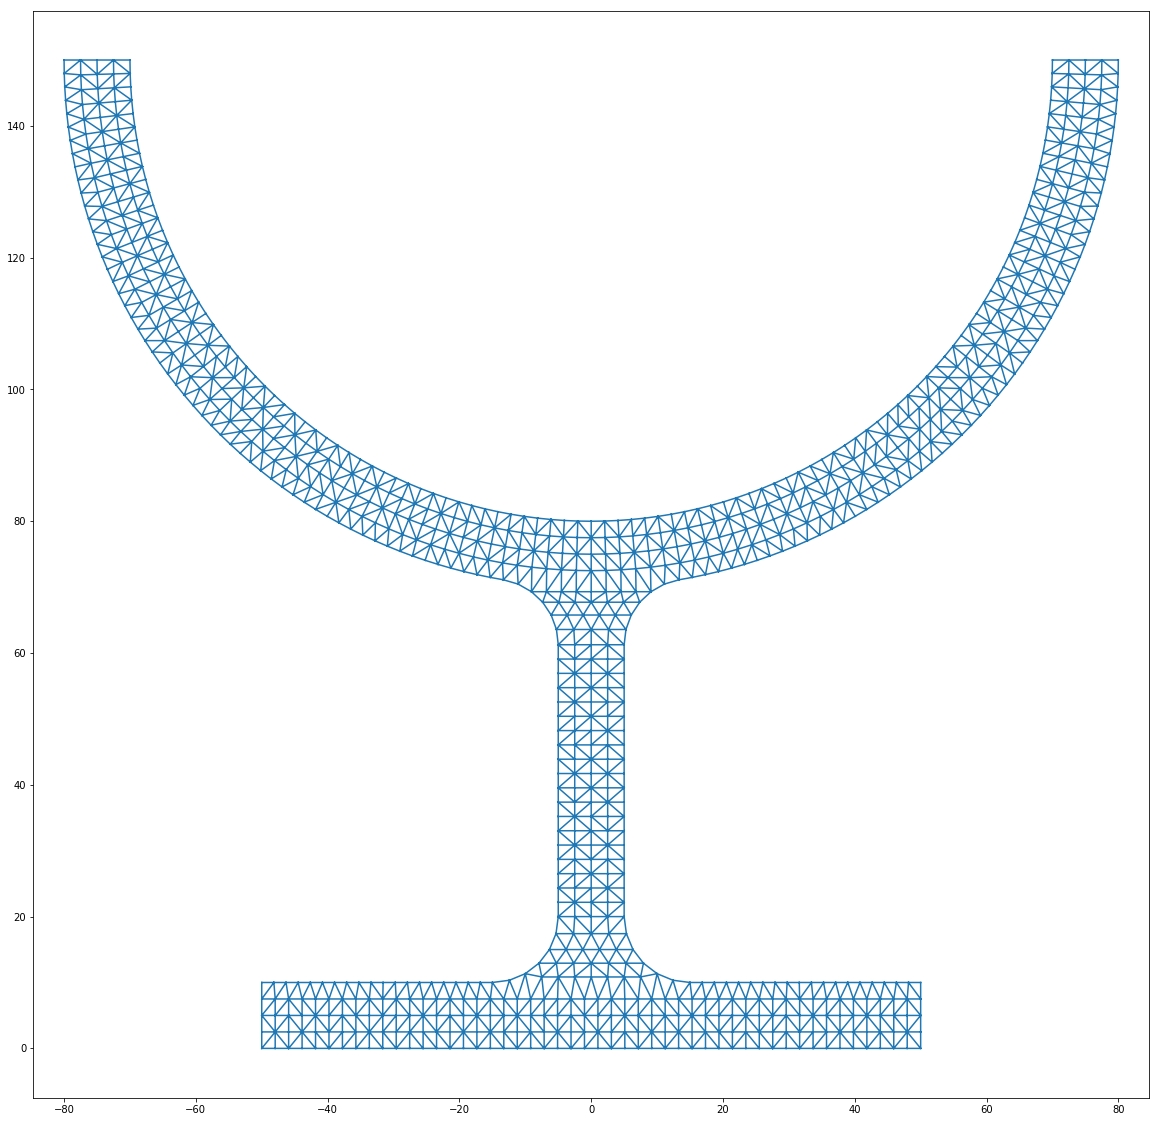

In [212]:
Nodes, simplices = construct_figure(10, 10)
plt.figure(figsize=(20, 20))
plt.triplot(Nodes[:, 0], Nodes[:, 1], simplices)
plt.axis('equal')

In [186]:
ee = np.array([[1, 2],
              [4, 5]])

In [187]:
ee

array([[1, 2],
       [4, 5]])

In [189]:
ee[:,0] -=1

In [190]:
ee

array([[0, 2],
       [3, 5]])

In [201]:
SPLITS_COEFF

0.5

In [202]:
W

15

In [204]:
W/W*SPLITS_COEFF

0.5